# Outcome Predictions Using TensorFlow

M.J. Madsen
2017-07-06

Using outcome model data generated by `\src\Generate_Outcome_History.ipynb`. Using the [TensorLayer](https://github.com/zsdonghao/tensorlayer) tool on top of TensorFlow.

In [1]:
import pandas as pd
from collections import Counter
import tensorflow as tf
import tensorlayer as tl
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [36]:
outcomes_df = pd.read_csv("../data/train_outcomes.csv")

print(outcomes_df.shape)
outcomes_df.head()

(100000, 23)


,clientID,resourceID,outcome,Cond_0,Cond_1,Cond_2,Cond_3,Cond_4,Cond_5,Cond_6,...,Cond_10,Cond_11,Cond_12,Cond_13,Cond_14,Cond_15,Cond_16,Cond_17,Cond_18,Cond_19
0,2,2,0,0.00,0.17,0.00,0.00,0.00,0.00,0.0,...,0.17,0.0,0.20,0.00,0.00,0.00,0.00,0.77,0.0,0.07
1,2,4,0,0.00,0.53,0.29,0.00,0.11,0.00,0.0,...,0.00,0.0,0.11,0.49,0.25,0.49,0.00,0.00,0.0,0.00
2,4,9,0,0.18,0.56,0.00,0.02,0.00,0.00,0.0,...,0.00,0.0,0.00,0.00,0.00,0.00,0.48,0.00,0.0,0.00
3,4,5,-1,0.00,0.00,0.00,0.00,0.00,0.00,0.0,...,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.37,0.0,0.00
4,5,4,0,0.39,0.06,0.00,0.00,0.00,0.18,0.0,...,0.22,0.0,0.00,0.23,0.15,0.00,0.00,0.00,0.0,0.42


Move both clientID and ResourceID to dummy columns

Set up initial dummies dataframe - we'll be joining more data to this as we go.

In [3]:
outcomes_df['clientID']  = outcomes_df['clientID'].astype('category')
outcomes_df['resourceID']  = outcomes_df['resourceID'].astype('category')
outcomes_df['outcome']  = outcomes_df['outcome'] + 1
outcomes_dum= pd.get_dummies(outcomes_df)
outcomes_dum.head()

,outcome,Cond_0,Cond_1,Cond_2,Cond_3,Cond_4,Cond_5,Cond_6,Cond_7,Cond_8,...,resourceID_10,resourceID_11,resourceID_12,resourceID_13,resourceID_14,resourceID_15,resourceID_16,resourceID_17,resourceID_18,resourceID_19
0,1,0.00,0.17,0.00,0.00,0.00,0.00,0.0,0.0,0.00,...,0,0,0,0,0,0,0,0,0,0
1,1,0.00,0.53,0.29,0.00,0.11,0.00,0.0,0.0,0.00,...,0,0,0,0,0,0,0,0,0,0
2,1,0.18,0.56,0.00,0.02,0.00,0.00,0.0,0.0,0.00,...,0,0,0,0,0,0,0,0,0,0
3,0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,...,0,0,0,0,0,0,0,0,0,0
4,1,0.39,0.06,0.00,0.00,0.00,0.18,0.0,0.0,0.11,...,0,0,0,0,0,0,0,0,0,0


## Train/Test split

Run the test/train split and Turn dataframes into arrays

In [4]:
labelcols=['outcome']
trainVal, test = train_test_split(outcomes_dum, test_size=0.2, random_state=42)
train, val = train_test_split(trainVal, test_size=0.1, random_state=42)
X_train = np.array(train.drop(labelcols,axis=1))
y_train = np.squeeze(np.array(train[labelcols]))
X_val = np.array(val.drop(labelcols,axis=1))
y_val = np.squeeze(np.array(val[labelcols]))
X_test = np.array(test.drop(labelcols,axis=1))
y_test = np.squeeze(np.array(test[labelcols]))

# Multilayer Perceptron:

http://tensorlayer.readthedocs.io/en/latest/user/tutorial.html


In [5]:
# Parameters
learning_rate = 0.0001
training_epochs = 200
batch_size = 500

# Network Parameters
n_hidden_1 = 256 # 1st layer number of features
n_hidden_2 = 256 # 2nd layer number of features
n_input = 60 # Input data shape: 3 sets of 20 dummy variables
n_classes = 3 # Three output classes: 0,1,2


In [6]:
with tf.Session() as sess:

    # define placeholder

    x = tf.placeholder(tf.float32, shape=[None, n_input], name='x')
    y_ = tf.placeholder(tf.int64, shape=[None, ], name='y_')

    # define the network
    network = tl.layers.InputLayer(x, name='input_layer')
    network = tl.layers.DropoutLayer(network, keep=0.8, name='drop1')
    network = tl.layers.DenseLayer(network, n_units=n_hidden_1,
                                    act = tf.nn.relu, name='relu1')
    network = tl.layers.DropoutLayer(network, keep=0.5, name='drop2')
    network = tl.layers.DenseLayer(network, n_units=n_hidden_2,
                                    act = tf.nn.relu, name='relu2')
    network = tl.layers.DropoutLayer(network, keep=0.5, name='drop3')
    # the softmax is implemented internally in tl.cost.cross_entropy(y, y_, 'cost') to
    # speed up computation, so we use identity here.
    # see tf.nn.sparse_softmax_cross_entropy_with_logits()
    network = tl.layers.DenseLayer(network, n_units=n_classes,
                                    act = tf.identity,
                                    name='output_layer')
    # define cost function and metric.
    y = network.outputs
    cost = tl.cost.cross_entropy(y, y_, 'cost')
    correct_prediction = tf.equal(tf.argmax(y, 1), y_)
    acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    y_op = tf.argmax(tf.nn.softmax(y), 1)
    y_prob = tf.nn.softmax(y) # Probabilities of outcomes
    # define the optimizer
    train_params = network.all_params
    train_op = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=0.9, beta2=0.999,
                                epsilon=1e-08, use_locking=False).minimize(cost, var_list=train_params)

    # initialize all variables in the session
    tl.layers.initialize_global_variables(sess)

    # print network information
    network.print_params()
    network.print_layers()

    # train the network
    tl.utils.fit(sess, network, train_op, cost, X_train, y_train, x, y_,
                acc=acc, batch_size=batch_size, n_epoch=training_epochs, print_freq=5,
                X_val=X_val, y_val=y_val, eval_train=False)

    # evaluation
    tl.utils.test(sess, network, acc, X_test, y_test, x, y_, batch_size=None, cost=cost)

    # save the network to .npz file
    tl.files.save_npz(network.all_params , name='../model/model.npz')


  [TL] InputLayer  input_layer: (?, 60)
  [TL] DropoutLayer drop1: keep:0.800000 is_fix:False
  [TL] DenseLayer  relu1: 256 relu
  [TL] DropoutLayer drop2: keep:0.500000 is_fix:False
  [TL] DenseLayer  relu2: 256 relu
  [TL] DropoutLayer drop3: keep:0.500000 is_fix:False
  [TL] DenseLayer  output_layer: 3 identity
  param   0: relu1/W:0            (60, 256)          float32_ref (mean: 0.001487838220782578, median: 0.002245685551315546, std: 0.08793740719556808)   
  param   1: relu1/b:0            (256,)             float32_ref (mean: 0.0               , median: 0.0               , std: 0.0               )   
  param   2: relu2/W:0            (256, 256)         float32_ref (mean: -0.0006163823418319225, median: -0.0009245526161976159, std: 0.08788260072469711)   
  param   3: relu2/b:0            (256,)             float32_ref (mean: 0.0               , median: 0.0               , std: 0.0               )   
  param   4: output_layer/W:0     (256, 3)           float32_ref (mean: 0.0020

In [7]:
with tf.Session() as sess:
    tl.files.load_and_assign_npz(sess=sess, name='../model/model.npz', network=network)
    predictions = tl.utils.predict(sess, network, X_test, x, y_op)


[*] Load model.npz SUCCESS!


In [8]:
actuals = y_test

cnf_matrix = confusion_matrix(actuals, predictions)
print(cnf_matrix)

[[ 903 1070    1]
 [ 108 9427  169]
 [   1 1213 7108]]


In [9]:
with tf.Session() as sess:
    tl.files.load_and_assign_npz(sess=sess, name='../model/model.npz', network=network)
    predprobs = tl.utils.predict(sess, network, X_test, x, y_prob)
predprobs

[*] Load model.npz SUCCESS!


array([[ 0.00925303,  0.8260802 ,  0.1646668 ],
       [ 0.00197568,  0.73594713,  0.26207715],
       [ 0.29786274,  0.51863778,  0.18349953],
       ..., 
       [ 0.01312506,  0.87291139,  0.1139635 ],
       [ 0.00149748,  0.37708628,  0.62141627],
       [ 0.07087875,  0.57476068,  0.35436055]], dtype=float32)

# Train Full Model

Now we can train the full model and compare the with-and-without predictions options


In [25]:
testing_df = pd.read_csv("../data/test_outcomes.csv")

print(testing_df.shape)
testing_df['clientID']  = testing_df['clientID'].astype('category')
testing_df['resourceID']  = testing_df['resourceID'].astype('category')
print(testing_df['clientID'].cat.categories )
print(testing_df['resourceID'].cat.categories )
testing_dum= pd.get_dummies(testing_df)
testing_dum.head()

(50000, 24)
Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
            19],
           dtype='int64')
Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
            19],
           dtype='int64')


,interactionID,outcome,Cond_0,Cond_1,Cond_2,Cond_3,Cond_4,Cond_5,Cond_6,Cond_7,...,resourceID_10,resourceID_11,resourceID_12,resourceID_13,resourceID_14,resourceID_15,resourceID_16,resourceID_17,resourceID_18,resourceID_19
0,0,0,0.0,0.0,0.12,0.0,0.0,0.0,0.15,0.0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0.0,0.0,0.12,0.0,0.0,0.0,0.15,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0.0,0.0,0.12,0.0,0.0,0.0,0.15,0.0,...,0,0,0,0,0,1,0,0,0,0
3,0,1,0.0,0.0,0.12,0.0,0.0,0.0,0.15,0.0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0.0,0.0,0.12,0.0,0.0,0.0,0.15,0.0,...,0,0,0,1,0,0,0,0,0,0


In [26]:
X_test_full = np.array(testing_dum.drop(labelcols + ['interactionID'],axis=1))
y_test_full = np.squeeze(np.array(testing_dum[labelcols])) + 1

X_train_full = np.array(outcomes_dum.drop(labelcols,axis=1))
y_train_full = np.squeeze(np.array(outcomes_dum[labelcols])) + 1
training_epochs = 300

In [8]:
with tf.Session() as sess:
    reuse = False
    with tf.variable_scope("model", reuse=reuse):
        tl.layers.set_name_reuse(reuse)
        # define placeholder

        x = tf.placeholder(tf.float32, shape=[None, n_input], name='x')
        y_ = tf.placeholder(tf.int64, shape=[None, ], name='y_')

        # define the network
        network = tl.layers.InputLayer(x, name='input_layer')
        network = tl.layers.DropoutLayer(network, keep=0.8, name='drop1')
        network = tl.layers.DenseLayer(network, n_units=n_hidden_1,
                                        act = tf.nn.relu, name='relu1')
        network = tl.layers.DropoutLayer(network, keep=0.5, name='drop2')
        network = tl.layers.DenseLayer(network, n_units=n_hidden_2,
                                        act = tf.nn.relu, name='relu2')
        network = tl.layers.DropoutLayer(network, keep=0.5, name='drop3')
        # the softmax is implemented internally in tl.cost.cross_entropy(y, y_, 'cost') to
        # speed up computation, so we use identity here.
        # see tf.nn.sparse_softmax_cross_entropy_with_logits()
        network = tl.layers.DenseLayer(network, n_units=n_classes,
                                        act = tf.identity,
                                        name='output_layer')
        # define cost function and metric.
        y = network.outputs
        cost = tl.cost.cross_entropy(y, y_, 'cost')
        correct_prediction = tf.equal(tf.argmax(y, 1), y_)
        acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        y_op = tf.argmax(tf.nn.softmax(y), 1)
        y_prob = tf.nn.softmax(y) # Probabilities of outcomes
        # define the optimizer
        train_params = network.all_params
        train_op = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=0.9, beta2=0.999,
                                    epsilon=1e-08, use_locking=False).minimize(cost, var_list=train_params)

        # initialize all variables in the session
        tl.layers.initialize_global_variables(sess)

        # print network information
        network.print_params()
        network.print_layers()

        # train the network
        tl.utils.fit(sess, network, train_op, cost, X_train_full, y_train_full, x, y_,
                    acc=acc, batch_size=batch_size, n_epoch=training_epochs, print_freq=5)

        # evaluation
        tl.utils.test(sess, network, acc, X_test_full, y_test_full, x, y_, batch_size=None, cost=cost)

        # save the network to .npz file
        tl.files.save_npz(network.all_params , name='../model/model_full.npz')

  [TL] InputLayer  model/input_layer: (?, 60)
  [TL] DropoutLayer model/drop1: keep:0.800000 is_fix:False
  [TL] DenseLayer  model/relu1: 256 relu
  [TL] DropoutLayer model/drop2: keep:0.500000 is_fix:False
  [TL] DenseLayer  model/relu2: 256 relu
  [TL] DropoutLayer model/drop3: keep:0.500000 is_fix:False
  [TL] DenseLayer  model/output_layer: 3 identity
  param   0: model/relu1/W:0      (60, 256)          float32_ref (mean: -0.0006148504326120019, median: -0.001722391927614808, std: 0.08874707669019699)   
  param   1: model/relu1/b:0      (256,)             float32_ref (mean: 0.0               , median: 0.0               , std: 0.0               )   
  param   2: model/relu2/W:0      (256, 256)         float32_ref (mean: 0.00035435400786809623, median: 0.0008961872663348913, std: 0.0878550112247467)   
  param   3: model/relu2/b:0      (256,)             float32_ref (mean: 0.0               , median: 0.0               , std: 0.0               )   
  param   4: model/output_layer/W:0

In [27]:
with tf.Session() as sess:
    tl.files.load_and_assign_npz(sess=sess, name='../model/model_full.npz', network=network)
    predprobs = tl.utils.predict(sess, network, X_test_full, x, y_prob)
predprobs

[*] Load model_full.npz SUCCESS!


array([[  1.24993488e-01,   6.21652603e-01,   2.53353924e-01],
       [  2.23392665e-01,   5.12244880e-01,   2.64362454e-01],
       [  1.29879698e-01,   5.81820428e-01,   2.88299829e-01],
       ..., 
       [  3.47372261e-05,   9.07308087e-02,   9.09234464e-01],
       [  5.12268007e-01,   4.63392526e-01,   2.43395213e-02],
       [  5.37874456e-03,   2.41440222e-01,   7.53181040e-01]], dtype=float32)

Calculate the overall "score" for each potential outcome:
> `-1 * prediction(-1) + prediction(1)`

In [28]:
score = -1*predprobs[:,0] + predprobs[:,2]
testing_df['score'] = score

In [30]:
predictions = np.argmax(predprobs,axis=1) - 1
cnf_matrix = confusion_matrix(np.array(testing_dum['outcome']), predictions)
print(cnf_matrix)

[[ 2661  2463     1]
 [  325 23476   294]
 [    0  3697 17083]]


In [31]:
baseratings = testing_df['outcome'][np.arange(0,len(testing_df),5)]
baseratings.mean()

0.3183

In [33]:
tgroups = testing_df.groupby('interactionID')
best_df = testing_df[['interactionID','clientID','resourceID','outcome']].loc[range(0,len(testing_df),5)].copy()
best_df['BestPrediction'] = 0
best_df.reset_index(inplace=True)
for gname, group in tgroups:
    bestrow = group['score'].argmax()
    best_df['BestPrediction'][gname]= (group['score'].ix[bestrow])
    best_df['outcome'][gname] = (group['outcome'].ix[bestrow])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [34]:
best_df.head()

,index,interactionID,clientID,resourceID,outcome,BestPrediction
0,0,0,15,17,1,0
1,5,1,9,8,1,0
2,10,2,10,13,1,0
3,15,3,6,19,1,0
4,20,4,17,11,1,0


 This is a huge improvement! Not surprising given that we are intentionally putting the best resource forward, but it is kind of surprising how big the improvment is.
 
 ## Visualize the improvement

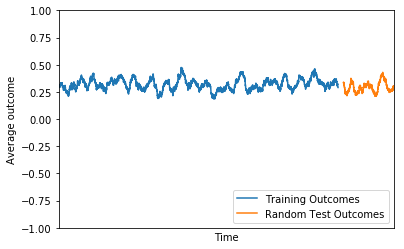

In [37]:
test_outcomes = len(testing_df)
test_rollmean = testing_df['outcome'].loc[range(0,test_outcomes,5)].rolling(200).mean()
outcome_rollmean_small = (outcomes_df['outcome'].rolling(200).mean())

priorpoints = 10000
plt.plot(np.arange(priorpoints),outcome_rollmean_small.values[-priorpoints:],label="Training Outcomes")
plt.plot(np.arange(len(test_rollmean))+priorpoints,test_rollmean.values,label="Random Test Outcomes")
plt.xticks([])
plt.xlim(0,priorpoints + 2000)
plt.xlabel('Time')
plt.ylabel('Average outcome')
plt.ylim(-1,1)
plt.legend(loc='lower right')


plt.show()

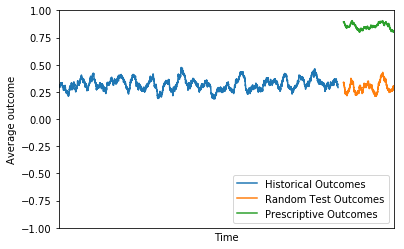

In [38]:
test_outcomes = len(testing_df)
test_rollmean = testing_df['outcome'].loc[range(0,test_outcomes,5)].rolling(200).mean()
outcome_rollmean_small = (outcomes_df['outcome'].rolling(200).mean())

best_df_rollmean = best_df['outcome'].rolling(200).mean()

priorpoints = 10000
plt.plot(np.arange(priorpoints),outcome_rollmean_small.values[-priorpoints:],label="Historical Outcomes")
plt.plot(np.arange(len(test_rollmean))+priorpoints,test_rollmean.values,label="Random Test Outcomes")
plt.plot(np.arange(len(test_rollmean))+priorpoints,best_df_rollmean.values,label="Prescriptive Outcomes")
plt.xticks([])
plt.xlim(0,priorpoints + 2000)
plt.xlabel('Time')
plt.ylabel('Average outcome')
plt.ylim(-1,1)
plt.legend(loc='lower right')
plt.savefig("../docs/train_test_best_rolling_average_tensorflow.png",dpi=300)
plt.show()
